***Библиотеки и данные***

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(open('data_description.txt').read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

***Первичный анализ***

Вид, отделка, год посмотройки и тд гаража предположительно можно убрать, оставив только общую оценку и состояние


Аналогично для др

***Подготовка данных***

*Заполнение пропусков*

In [4]:
pd.unique(data.dtypes)

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [5]:
cat = []
num = []

for x in data.columns:
    if data.dtypes[x]=='object':
        cat.append(x)
    else:
        num.append(x)

In [6]:
for x in data.columns:
    nulls = data[x].isnull().sum()
    nulls_proc = nulls/data.shape[0]*100
    if nulls != 0:
        print(x, ': ', round(nulls_proc,2), '%', sep='')
        if x in cat:
            print(data[x].unique())
        print('\n')

LotFrontage: 17.74%


Alley: 93.77%
[nan 'Grvl' 'Pave']


MasVnrType: 0.55%
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


MasVnrArea: 0.55%


BsmtQual: 2.53%
['Gd' 'TA' 'Ex' nan 'Fa']


BsmtCond: 2.53%
['TA' 'Gd' nan 'Fa' 'Po']


BsmtExposure: 2.6%
['No' 'Gd' 'Mn' 'Av' nan]


BsmtFinType1: 2.53%
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']


BsmtFinType2: 2.6%
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']


Electrical: 0.07%
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


FireplaceQu: 47.26%
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


GarageType: 5.55%
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


GarageYrBlt: 5.55%


GarageFinish: 5.55%
['RFn' 'Unf' 'Fin' nan]


GarageQual: 5.55%
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']


GarageCond: 5.55%
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


PoolQC: 99.52%
[nan 'Ex' 'Fa' 'Gd']


Fence: 80.75%
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


MiscFeature: 96.3%
[nan 'Shed' 'Gar2' 'Othr' 'TenC']




В фичах, где вариант отсутствующего значения предусмотен, заменяем nan на строку 'NA' (0 в случае LotFrontage), в остальных случаях пропуски заполяем модой/медианой

In [7]:
data['LotFrontage'] = data['LotFrontage'].replace(np.nan, 0)

In [8]:
data['Alley'] = data['Alley'].replace(np.nan, 'NA')

In [9]:
data['MasVnrType'] = data['MasVnrType'].replace(np.nan, data['MasVnrType'].mode()[0])

In [10]:
data['MasVnrArea'] = data['MasVnrArea'].replace(np.nan, data['MasVnrArea'].mode()[0])

In [11]:
data['BsmtQual'] = data['BsmtQual'].replace(np.nan, 'NA')

In [12]:
data['BsmtCond'] = data['BsmtCond'].replace(np.nan, 'NA')

In [13]:
data['BsmtExposure'] = data['BsmtExposure'].replace(np.nan, 'NA')

In [14]:
data['BsmtFinType1'] = data['BsmtFinType1'].replace(np.nan, 'NA')

In [15]:
data['BsmtFinType2'] = data['BsmtFinType2'].replace(np.nan, 'NA')

In [16]:
ind=[]
for x,y in data['Electrical'].isnull().to_dict().items():
    if y==True:
        ind.append(x)
pd.set_option('display.max_columns', 81)
data.iloc[ind]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [17]:
pd.reset_option('display.max_columns')

In [18]:
data['Electrical'] = data['Electrical'].replace(np.nan, data['Electrical'].mode()[0])

In [19]:
data['FireplaceQu'] = data['FireplaceQu'].replace(np.nan, 'NA')

In [20]:
data['GarageType'] = data['GarageType'].replace(np.nan, 'NA')

In [21]:
data['GarageYrBlt'] = data['GarageYrBlt'].replace(np.nan, data['GarageYrBlt'].median())

In [22]:
data['GarageFinish'] = data['GarageFinish'].replace(np.nan, 'NA')

In [23]:
data['GarageQual'] = data['GarageQual'].replace(np.nan, 'NA')

In [24]:
data['GarageCond'] = data['GarageQual'].replace(np.nan, 'NA')

In [25]:
data['PoolQC'] = data['PoolQC'].replace(np.nan, 'NA')

In [26]:
data['Fence'] = data['Fence'].replace(np.nan, 'NA')

In [27]:
data['MiscFeature'] = data['MiscFeature'].replace(np.nan, 'NA')

In [28]:
for x in data.columns:
    nulls = data[x].isnull().sum()
nulls

0

*Проверка уникальности строк*

In [29]:
data.duplicated().unique()
data.duplicated(subset='Id').unique()

array([False])

*Контроль выбросов*

*Перебор признаков*

Корреляция для количественных признаков

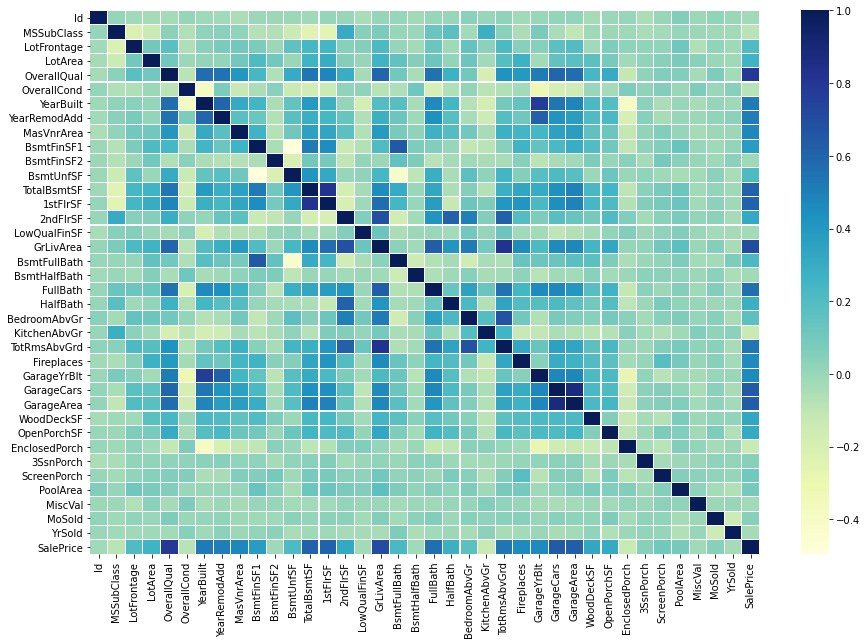

In [30]:
corr = data.corr()
plt.subplots(figsize=(15, 10))
sns.heatmap(corr, cmap='YlGnBu', linewidths=.1)

У некоторых признаков между собой присутствует объяснимая корреляция (напр. год постройки дома/год постройки гаража)

In [31]:
target_corr = data.corr()['SalePrice'].to_frame().sort_values(by='SalePrice', ascending=False)
target_corr.style.background_gradient(cmap='YlGnBu')

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Из числовых признаков будем использовать только 0.3+ коррелирующие с таргетом признаки

In [32]:
num_feats = target_corr.index[:11]
num_feats = list(num_feats)
num_feats

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

In [33]:
data['YearBuilt'].corr(data['YearRemodAdd'])

0.5928549763436503

In [34]:
data['YearBuilt'].corr(data['OverallQual'])

0.5723227689623615

По тепловой карте видно, что GarageCars и GarageArea коррелируют друг с другом, поэтому оставим только признак GarageArea

1stFlrSF повторяет TotalBsmtSF, исключаем его 

FullBath и TotRmsAbvGrd идут рука об руку с общим метражом, тоже не учитываем

YearBuilt и YearRemodAdd имеют большую корреляцию между собой и с OverallQual, чем с таргетом; по логике эти признаки должны иметь вес, но вполне возможно, что они в достаточной мере учтены в общей оценке дома, пока оставим

In [35]:
for x in ['GarageCars', '1stFlrSF', 'FullBath','TotRmsAbvGrd']:
    num_feats.remove(x) 

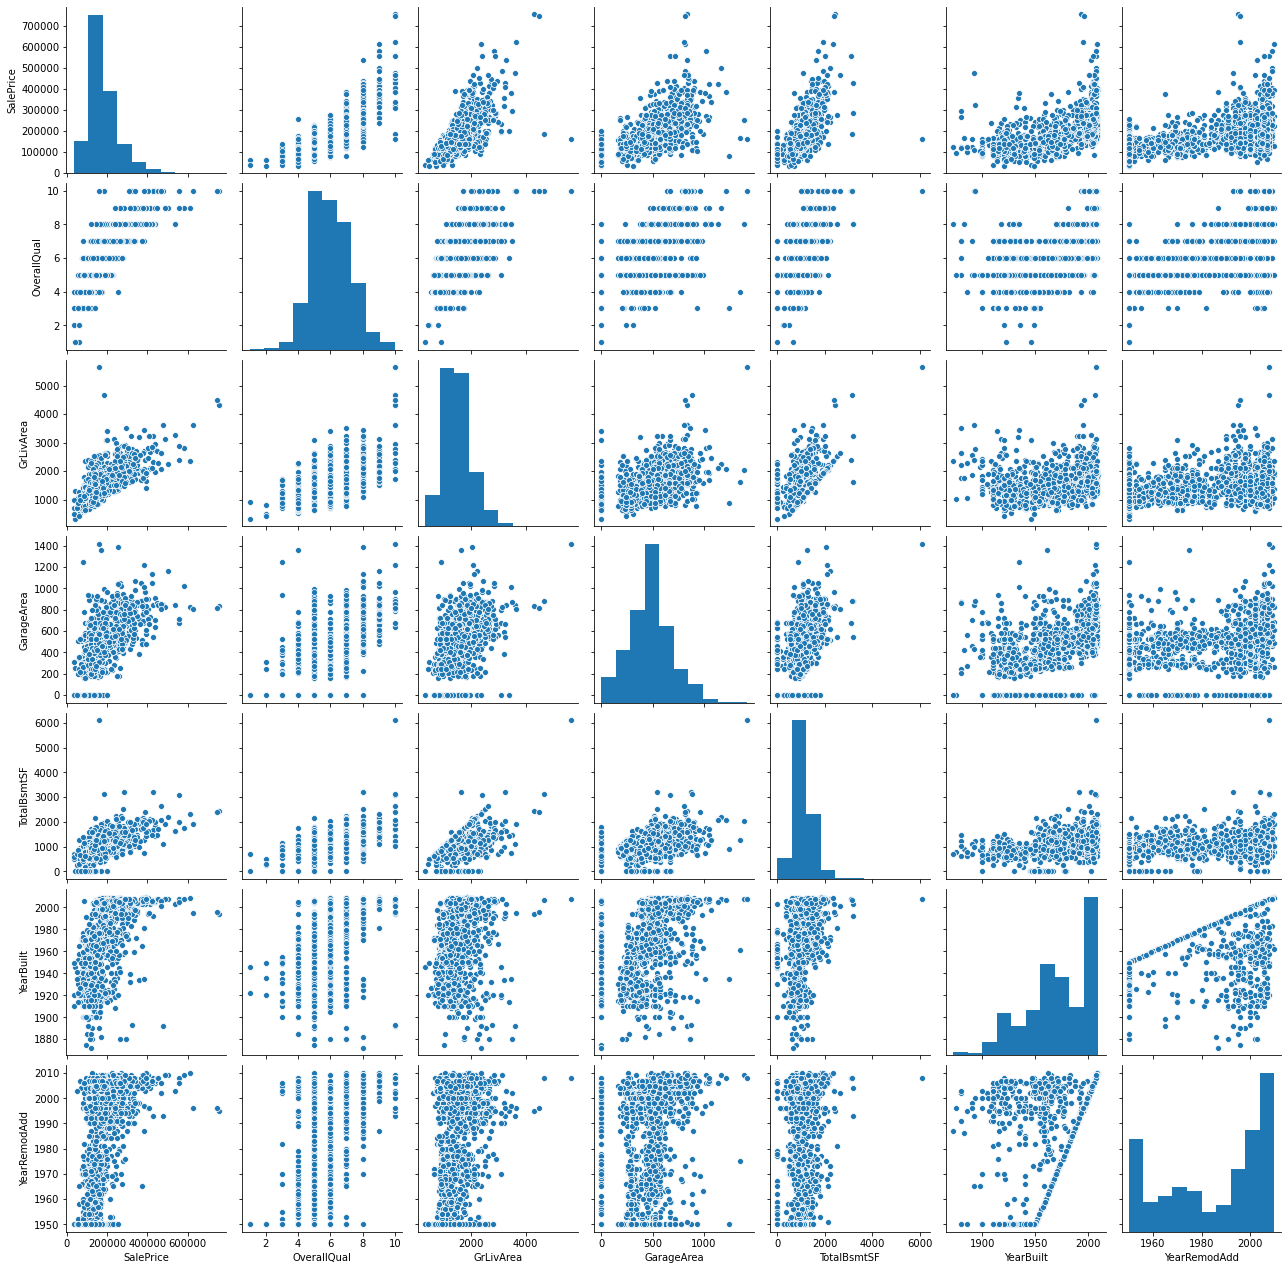

In [36]:
sns.pairplot(data[num_feats], height=2.5)

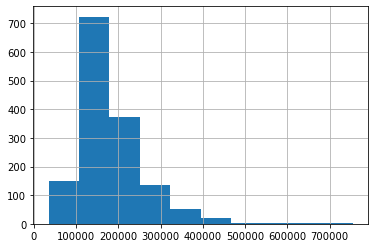

In [37]:
data['SalePrice'].hist()

In [38]:
data['SalePrice'] = np.log(data['SalePrice'])

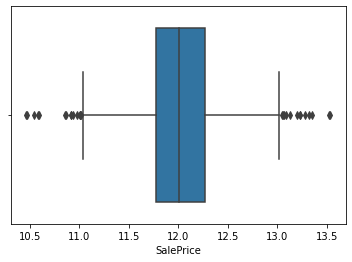

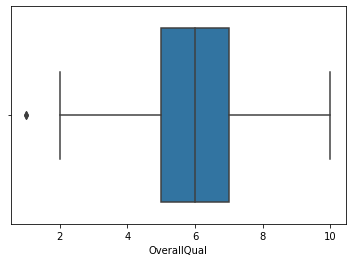

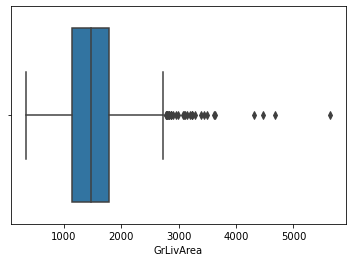

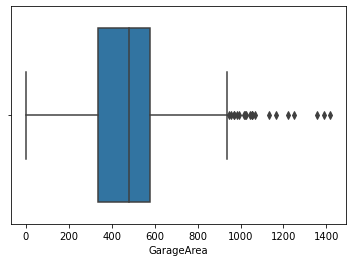

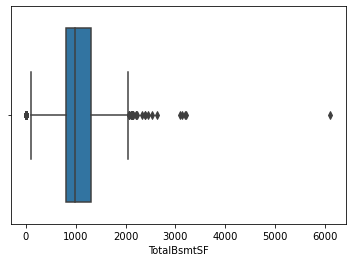

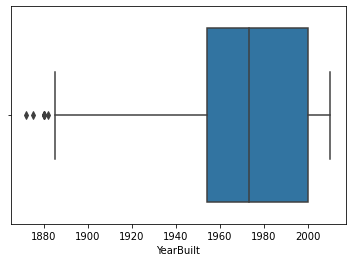

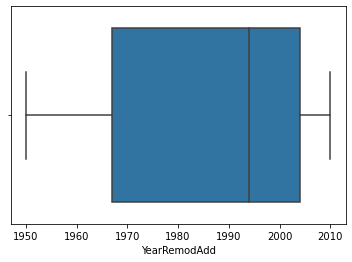

In [39]:
for x in num_feats:
    plt.show(sns.boxplot(data[x]))

In [40]:
data['SalePrice'] = data['SalePrice'].clip(10.8,13.4)

In [41]:
data['OverallQual'] = data['OverallQual'].clip(2,10)

In [42]:
data['GrLivArea'] = data['GrLivArea'].clip(0,3800)

In [43]:
data['GarageArea'] = data['GarageArea'].clip(0,1300)

In [44]:
data['TotalBsmtSF'] = data['TotalBsmtSF'].clip(100,2700)

In [45]:
data['YearBuilt'] = data['YearBuilt'].clip(1900,5000)

In [46]:
data['YearRemodAdd'] = data['YearRemodAdd'].clip(0,5000)

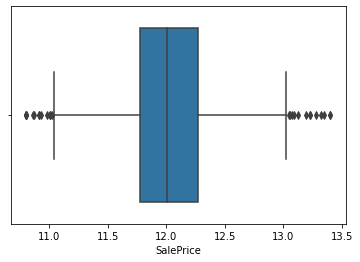

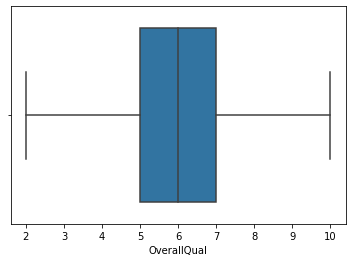

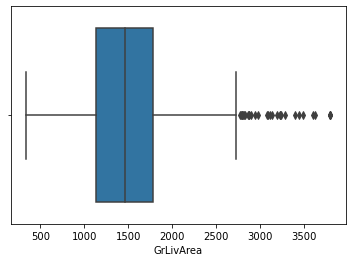

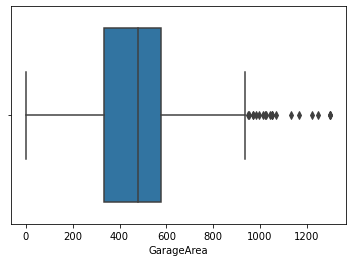

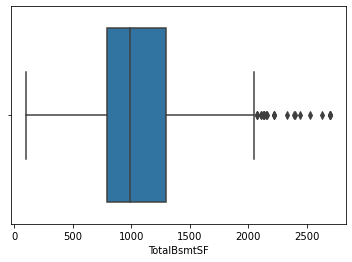

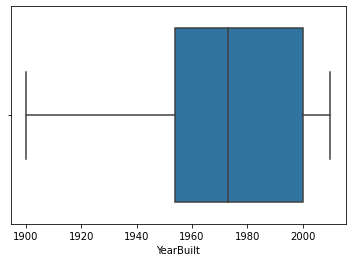

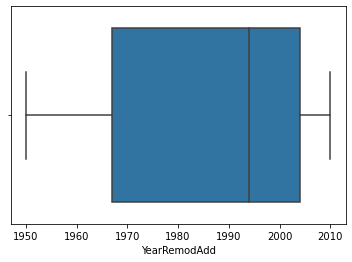

In [47]:
for x in num_feats:
    plt.show(sns.boxplot(data[x]))

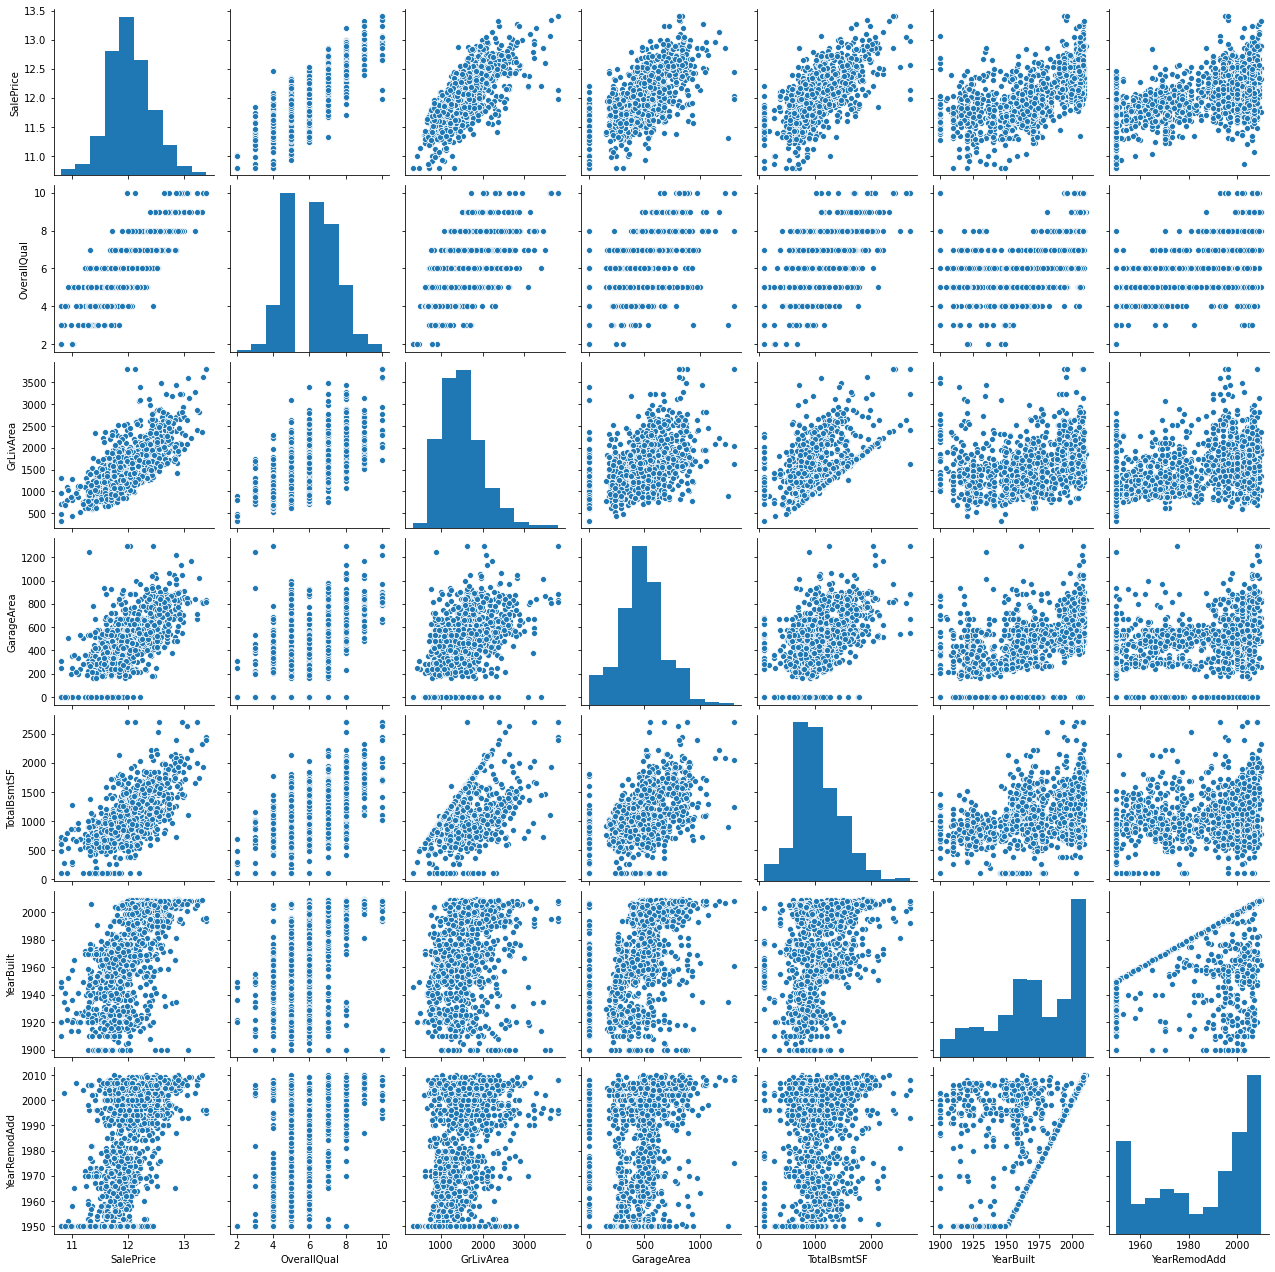

In [48]:
sns.pairplot(data[num_feats], height=2.5)

Теперь выбранные признаки очень грубо, но выглядят линейно скореелированными с целевой переменной

Разберем категориальные признаки

Поскольку мы не можем отобрать их в зависимости от корреляции, можно рискнуть дропнуть сильно не сбалансированные признаки (напр., если больше 75% это одна категория, то удаляем), а также найти по описанию и убрать те, что повторяют информацию из другого столбца (если оставнется много, рискнем отбросить незначимые по личному мнению)

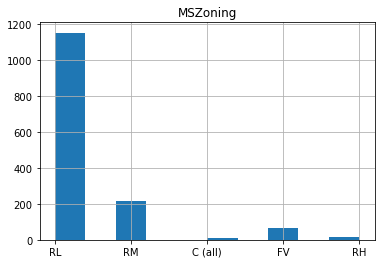

MSZoning
C (all)    0.01
FV         0.04
RH         0.01
RL         0.79
RM         0.15
dtype: float64
__________________________________________________


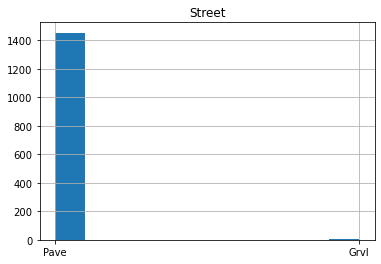

Street
Grvl    0.0
Pave    1.0
dtype: float64
__________________________________________________


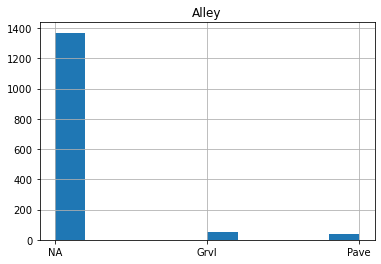

Alley
Grvl    0.03
NA      0.94
Pave    0.03
dtype: float64
__________________________________________________


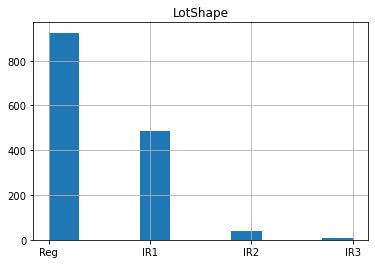

LotShape
IR1    0.33
IR2    0.03
IR3    0.01
Reg    0.63
dtype: float64
__________________________________________________


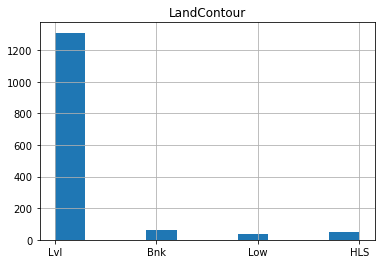

LandContour
Bnk    0.04
HLS    0.03
Low    0.02
Lvl    0.90
dtype: float64
__________________________________________________


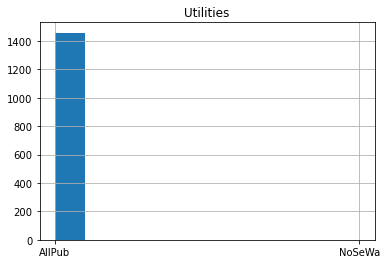

Utilities
AllPub    1.0
NoSeWa    0.0
dtype: float64
__________________________________________________


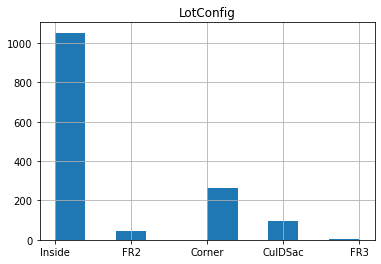

LotConfig
Corner     0.18
CulDSac    0.06
FR2        0.03
FR3        0.00
Inside     0.72
dtype: float64
__________________________________________________


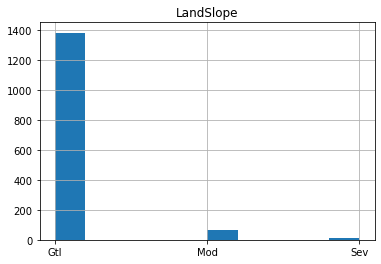

LandSlope
Gtl    0.95
Mod    0.04
Sev    0.01
dtype: float64
__________________________________________________


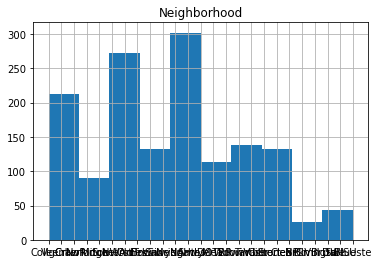

Neighborhood
Blmngtn    0.01
Blueste    0.00
BrDale     0.01
BrkSide    0.04
ClearCr    0.02
CollgCr    0.10
Crawfor    0.03
Edwards    0.07
Gilbert    0.05
IDOTRR     0.03
MeadowV    0.01
Mitchel    0.03
NAmes      0.15
NPkVill    0.01
NWAmes     0.05
NoRidge    0.03
NridgHt    0.05
OldTown    0.08
SWISU      0.02
Sawyer     0.05
SawyerW    0.04
Somerst    0.06
StoneBr    0.02
Timber     0.03
Veenker    0.01
dtype: float64
__________________________________________________


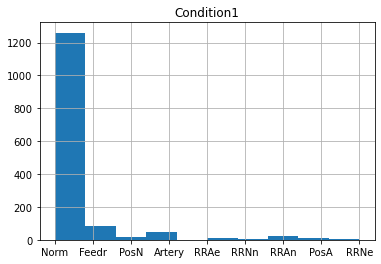

Condition1
Artery    0.03
Feedr     0.06
Norm      0.86
PosA      0.01
PosN      0.01
RRAe      0.01
RRAn      0.02
RRNe      0.00
RRNn      0.00
dtype: float64
__________________________________________________


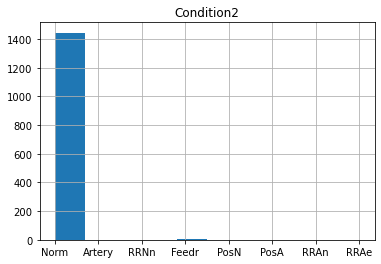

Condition2
Artery    0.00
Feedr     0.00
Norm      0.99
PosA      0.00
PosN      0.00
RRAe      0.00
RRAn      0.00
RRNn      0.00
dtype: float64
__________________________________________________


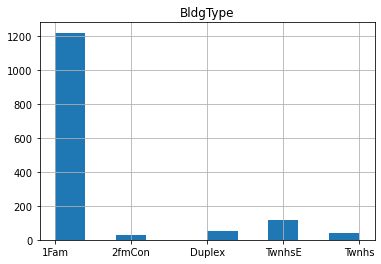

BldgType
1Fam      0.84
2fmCon    0.02
Duplex    0.04
Twnhs     0.03
TwnhsE    0.08
dtype: float64
__________________________________________________


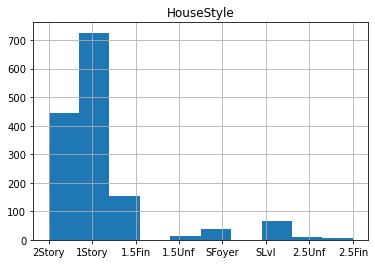

HouseStyle
1.5Fin    0.11
1.5Unf    0.01
1Story    0.50
2.5Fin    0.01
2.5Unf    0.01
2Story    0.30
SFoyer    0.03
SLvl      0.04
dtype: float64
__________________________________________________


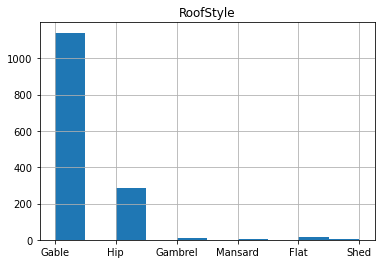

RoofStyle
Flat       0.01
Gable      0.78
Gambrel    0.01
Hip        0.20
Mansard    0.00
Shed       0.00
dtype: float64
__________________________________________________


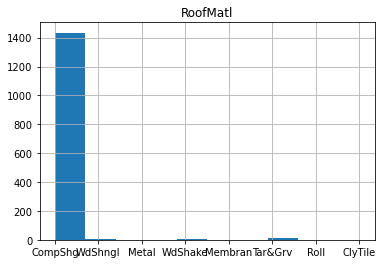

RoofMatl
ClyTile    0.00
CompShg    0.98
Membran    0.00
Metal      0.00
Roll       0.00
Tar&Grv    0.01
WdShake    0.00
WdShngl    0.00
dtype: float64
__________________________________________________


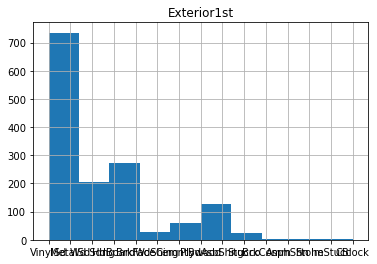

Exterior1st
AsbShng    0.01
AsphShn    0.00
BrkComm    0.00
BrkFace    0.03
CBlock     0.00
CemntBd    0.04
HdBoard    0.15
ImStucc    0.00
MetalSd    0.15
Plywood    0.07
Stone      0.00
Stucco     0.02
VinylSd    0.35
Wd Sdng    0.14
WdShing    0.02
dtype: float64
__________________________________________________


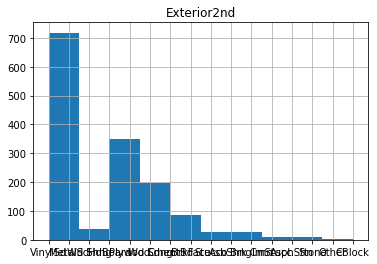

Exterior2nd
AsbShng    0.01
AsphShn    0.00
Brk Cmn    0.00
BrkFace    0.02
CBlock     0.00
CmentBd    0.04
HdBoard    0.14
ImStucc    0.01
MetalSd    0.15
Other      0.00
Plywood    0.10
Stone      0.00
Stucco     0.02
VinylSd    0.35
Wd Sdng    0.13
Wd Shng    0.03
dtype: float64
__________________________________________________


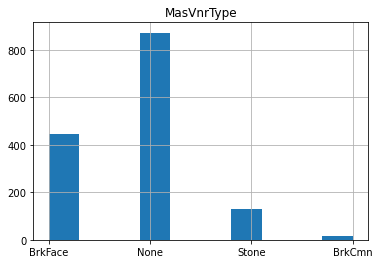

MasVnrType
BrkCmn     0.01
BrkFace    0.30
None       0.60
Stone      0.09
dtype: float64
__________________________________________________


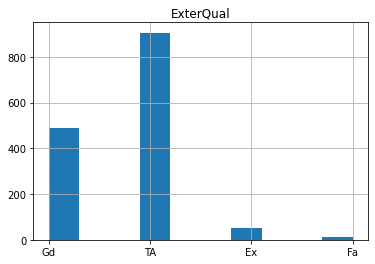

ExterQual
Ex    0.04
Fa    0.01
Gd    0.33
TA    0.62
dtype: float64
__________________________________________________


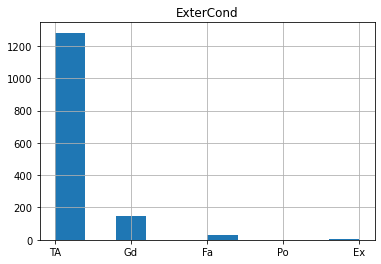

ExterCond
Ex    0.00
Fa    0.02
Gd    0.10
Po    0.00
TA    0.88
dtype: float64
__________________________________________________


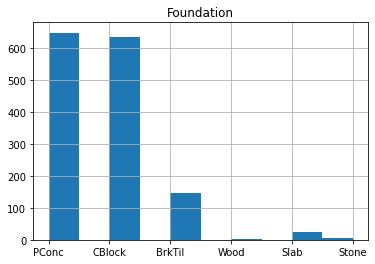

Foundation
BrkTil    0.10
CBlock    0.43
PConc     0.44
Slab      0.02
Stone     0.00
Wood      0.00
dtype: float64
__________________________________________________


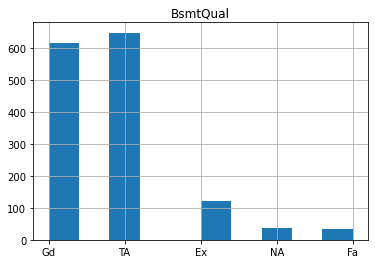

BsmtQual
Ex    0.08
Fa    0.02
Gd    0.42
NA    0.03
TA    0.44
dtype: float64
__________________________________________________


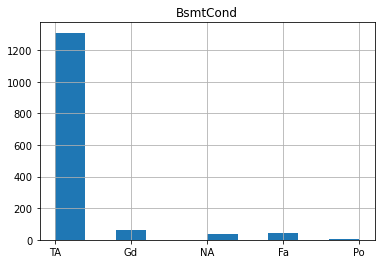

BsmtCond
Fa    0.03
Gd    0.04
NA    0.03
Po    0.00
TA    0.90
dtype: float64
__________________________________________________


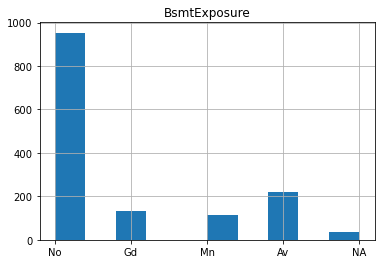

BsmtExposure
Av    0.15
Gd    0.09
Mn    0.08
NA    0.03
No    0.65
dtype: float64
__________________________________________________


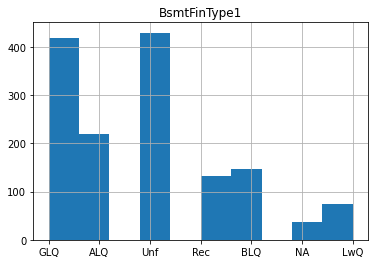

BsmtFinType1
ALQ    0.15
BLQ    0.10
GLQ    0.29
LwQ    0.05
NA     0.03
Rec    0.09
Unf    0.29
dtype: float64
__________________________________________________


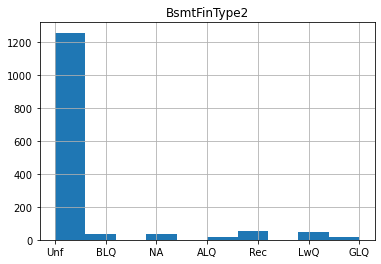

BsmtFinType2
ALQ    0.01
BLQ    0.02
GLQ    0.01
LwQ    0.03
NA     0.03
Rec    0.04
Unf    0.86
dtype: float64
__________________________________________________


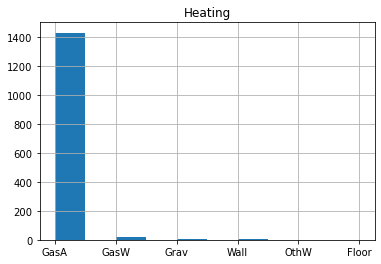

Heating
Floor    0.00
GasA     0.98
GasW     0.01
Grav     0.00
OthW     0.00
Wall     0.00
dtype: float64
__________________________________________________


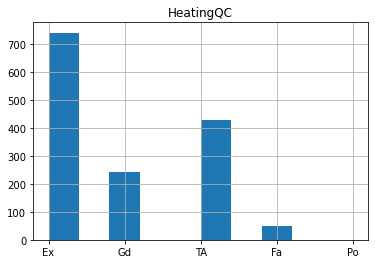

HeatingQC
Ex    0.51
Fa    0.03
Gd    0.17
Po    0.00
TA    0.29
dtype: float64
__________________________________________________


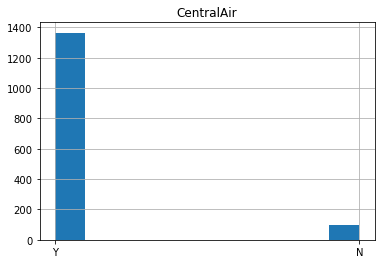

CentralAir
N    0.07
Y    0.93
dtype: float64
__________________________________________________


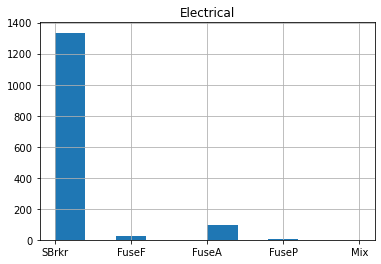

Electrical
FuseA    0.06
FuseF    0.02
FuseP    0.00
Mix      0.00
SBrkr    0.91
dtype: float64
__________________________________________________


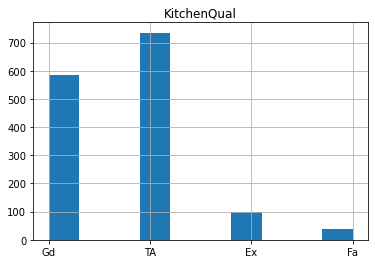

KitchenQual
Ex    0.07
Fa    0.03
Gd    0.40
TA    0.50
dtype: float64
__________________________________________________


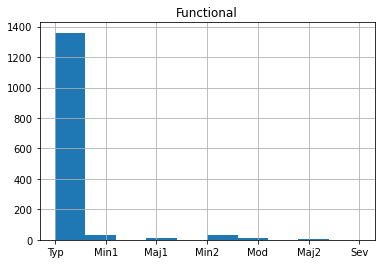

Functional
Maj1    0.01
Maj2    0.00
Min1    0.02
Min2    0.02
Mod     0.01
Sev     0.00
Typ     0.93
dtype: float64
__________________________________________________


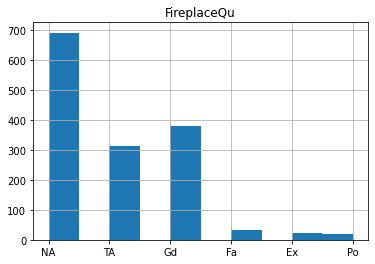

FireplaceQu
Ex    0.02
Fa    0.02
Gd    0.26
NA    0.47
Po    0.01
TA    0.21
dtype: float64
__________________________________________________


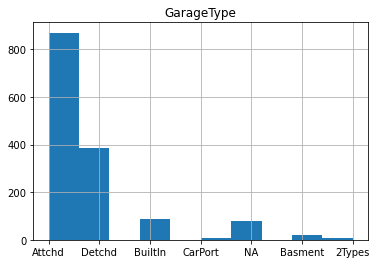

GarageType
2Types     0.00
Attchd     0.60
Basment    0.01
BuiltIn    0.06
CarPort    0.01
Detchd     0.27
NA         0.06
dtype: float64
__________________________________________________


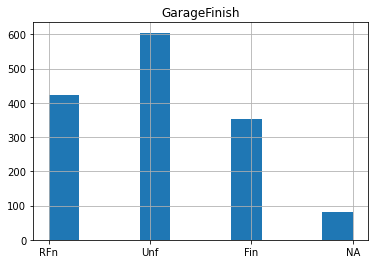

GarageFinish
Fin    0.24
NA     0.06
RFn    0.29
Unf    0.41
dtype: float64
__________________________________________________


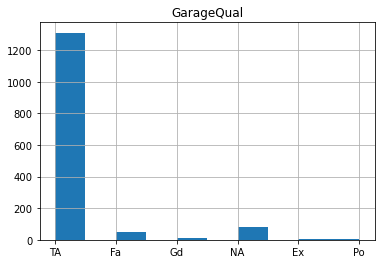

GarageQual
Ex    0.00
Fa    0.03
Gd    0.01
NA    0.06
Po    0.00
TA    0.90
dtype: float64
__________________________________________________


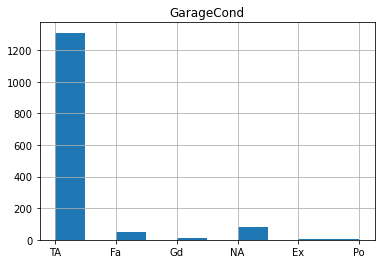

GarageCond
Ex    0.00
Fa    0.03
Gd    0.01
NA    0.06
Po    0.00
TA    0.90
dtype: float64
__________________________________________________


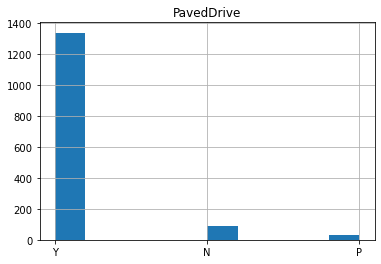

PavedDrive
N    0.06
P    0.02
Y    0.92
dtype: float64
__________________________________________________


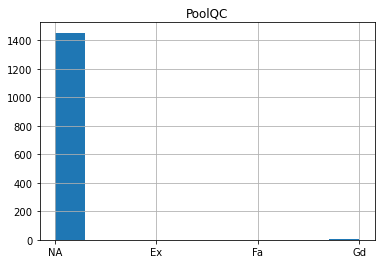

PoolQC
Ex    0.0
Fa    0.0
Gd    0.0
NA    1.0
dtype: float64
__________________________________________________


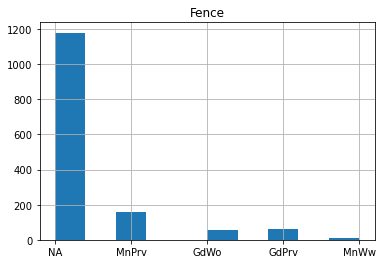

Fence
GdPrv    0.04
GdWo     0.04
MnPrv    0.11
MnWw     0.01
NA       0.81
dtype: float64
__________________________________________________


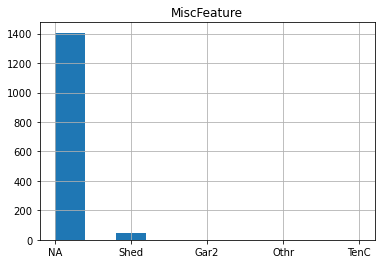

MiscFeature
Gar2    0.00
NA      0.96
Othr    0.00
Shed    0.03
TenC    0.00
dtype: float64
__________________________________________________


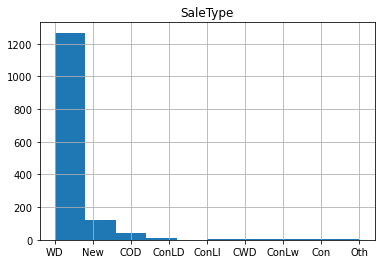

SaleType
COD      0.03
CWD      0.00
Con      0.00
ConLD    0.01
ConLI    0.00
ConLw    0.00
New      0.08
Oth      0.00
WD       0.87
dtype: float64
__________________________________________________


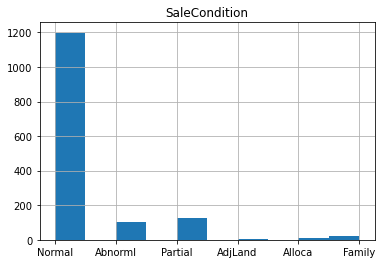

SaleCondition
Abnorml    0.07
AdjLand    0.00
Alloca     0.01
Family     0.01
Normal     0.82
Partial    0.09
dtype: float64
__________________________________________________


In [49]:
cat_del = []

for x in cat:
    plt.title(x)
    plt.show(data[x].hist())
    
    df_x = data[x].to_frame()
    df_x_size = df_x.groupby(x).size()
    df_x_size_prop = df_x_size.div(df_x_size.sum())
            
    print(round(df_x_size_prop, 2))
    print('_'*50)
    
    for i in df_x_size_prop:
        if i > 0.75:
            cat_del.append(x)

In [50]:
print(cat_del, sep='')

['MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [51]:
cat_feats = cat

In [52]:
for x in cat_del:
    cat_feats.remove(x)
print(cat_feats, sep='')

['LotShape', 'LotConfig', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish']


In [53]:
for x in ['LotShape', 'MasVnrType', 'BsmtExposure', 'Exterior1st', 'Exterior2nd', 'FireplaceQu']:
        cat_feats.remove(x)

In [54]:
print(cat_feats, sep='')

['LotConfig', 'Neighborhood', 'HouseStyle', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish']


Данные, с которыми, исходя из обработки, должна работать модель:

In [55]:
cols = num_feats+cat_feats
data_new = data[cols]
features = cols
features.remove('SalePrice')
data_new.head()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,YearRemodAdd,LotConfig,Neighborhood,HouseStyle,ExterQual,Foundation,BsmtQual,BsmtFinType1,HeatingQC,KitchenQual,GarageType,GarageFinish
0,12.247694,7,1710,548,856,2003,2003,Inside,CollgCr,2Story,Gd,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn
1,12.109011,6,1262,460,1262,1976,1976,FR2,Veenker,1Story,TA,CBlock,Gd,ALQ,Ex,TA,Attchd,RFn
2,12.317167,7,1786,608,920,2001,2002,Inside,CollgCr,2Story,Gd,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn
3,11.849398,7,1717,642,756,1915,1970,Corner,Crawfor,2Story,TA,BrkTil,TA,ALQ,Gd,Gd,Detchd,Unf
4,12.429216,8,2198,836,1145,2000,2000,FR2,NoRidge,2Story,Gd,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn


Прогоним весь изначальный датасет через RandomForestRegressor, чтобы посмотреть, какие признаки он посчитает наиболее важными

In [56]:
X = pd.get_dummies(data.drop(columns='SalePrice'))
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = RandomForestRegressor()

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8693129258974885

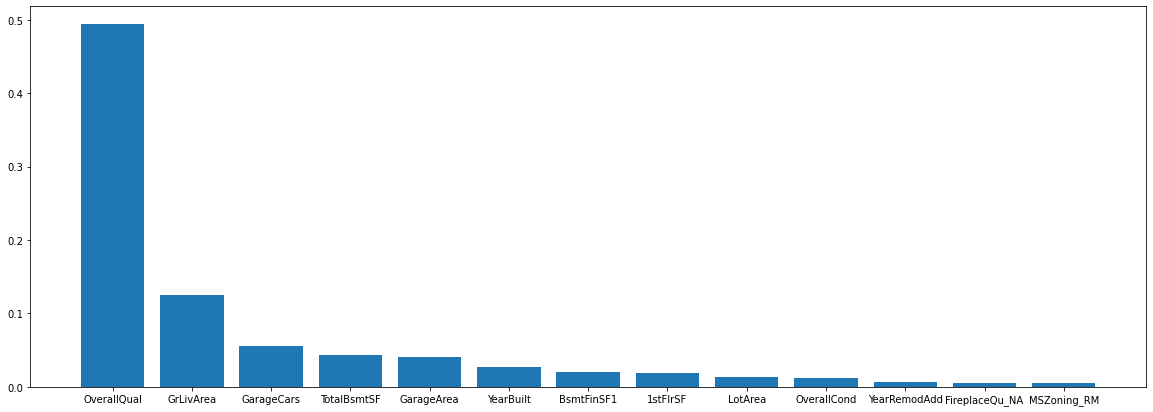

In [57]:
importances = model.feature_importances_
N = len(features)

f_index = np.argsort(importances)[::-1][:N]
fs = {}
for x in range(len(X.columns)):
    fs[x] = X.columns[x]

RF_features = [fs[i] for i in f_index]

plt.figure(figsize=(20, 7))
plt.bar(range(13), importances[f_index][:13])
plt.xticks(range(13), RF_features[:13])
plt.show()

In [58]:
f = []
rf_f = []
for x in RF_features:
    if x not in features:
        rf_f.append(x)
        
for x in features:
    if x not in RF_features:
        f.append(x)

features_types=[]
for x in f:
    if x in num:
        features_types.append('колич.')
    else:
        features_types.append('качеств.')

RF_features_types=[]
for x in rf_f:
    if x in num:
        RF_features_types.append('колич.')
    else:
        RF_features_types.append('качеств.')

In [59]:
df = pd.DataFrame({'Вручную': f, 'Тип': features_types, 'RandomForest': rf_f, 'ТипRF': RF_features_types})
df

,Вручную,Тип,RandomForest,ТипRF
0,LotConfig,качеств.,GarageCars,колич.
1,Neighborhood,качеств.,BsmtFinSF1,колич.
2,HouseStyle,качеств.,1stFlrSF,колич.
3,ExterQual,качеств.,LotArea,колич.
4,Foundation,качеств.,OverallCond,колич.
5,BsmtQual,качеств.,FireplaceQu_NA,качеств.
6,BsmtFinType1,качеств.,MSZoning_RM,качеств.
7,HeatingQC,качеств.,2ndFlrSF,колич.
8,KitchenQual,качеств.,GarageYrBlt,колич.
9,GarageType,качеств.,KitchenAbvGr,колич.


Глядя на feature_importances_ с уверенностью удаляем все качественные признаки из таблицы

In [60]:
for x in f:
    features.remove(x) 

In [61]:
data_new = data_new[features]

Потестим RandomForestRegressor на наших данных

In [64]:
X = pd.get_dummies(data_new)
#y = data_new['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = RandomForestRegressor()

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8282605512580327

In [ ]:
base_models = [('LR', LinearRegression()), ('kNR', KNeighborsRegressor()), ('DTR', DecisionTreeRegressor())]
meta_model = GradientBoostingRegressor()

model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [ ]:
models = dict(base_models)
models['stack'] = meta_model

for name, model in models.items():
    scores = cross_val_score(model, X, y)
    print(name, round(np.mean(scores), 3))